# Dogs vs. Cats Redux: Kernels Edition

## Overview

Distinguish images of dogs from cats using a pretrained image recognition model *VGG16*.

See [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

## Basic Setup

In [1]:
# Show plots on the page
%matplotlib inline

Load required libraries:

In [2]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [8]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.preprocessing import image

Load [fast.ai's](course.fast.ai) module:

In [3]:
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed
# %load_ext autoreload
# %autoreload 2

from libs.utils import plot_confusion_matrix
from libs.vgg16 import Vgg16

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


## Train linear model on predictions

Define path to the dataset:

In [4]:
path = "data/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

Create Vgg16 object

In [5]:
vgg = Vgg16()
model = vgg.model

In [6]:
batch_size = 64
target_size = (224,224)

Our overall approach here will be:
1. Get the true labels for every image
2. Get the 1,000 imagenet category predictions for every image
3. Feed these predictions as input to a simple linear model.

Let's start by grabbing training and validation batches.

In [9]:
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(path+'train', target_size, shuffle=False, batch_size=batch_size)
val_batches = gen.flow_from_directory(path+'valid', target_size, shuffle=False, batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Grab the data

In [7]:
trn_data = np.concatenate([batches.next() for i in range(batches.nb_sample)])
val_data = np.concatenate([val_batches.next() for i in range(val_batches.nb_sample)])

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [10]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

Save them for future use

In [8]:
save_array(model_path+ 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc', val_data)

So they can be loaded as follows:

In [11]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

Keras returns classes as a single column, so we convert to one hot encoding

In [12]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [13]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [15]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [16]:
trn_features.shape

(23000, 1000)

Save numpy arrays

In [19]:
save_array(model_path+ 'train_lastlayer_features.bc', trn_features)
save_array(model_path + 'valid_lastlayer_features.bc', val_features)

Load training and validation features later without recalculating them:

In [14]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

Define the linear model

In [15]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

Fit the model

In [16]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=4, 
       validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 8s - loss: 0.1354 - acc: 0.9702 - val_loss: 0.1473 - val_acc: 0.9780
Epoch 2/3
23000/23000 [==============================] - 9s - loss: 0.1619 - acc: 0.9740 - val_loss: 0.1783 - val_acc: 0.9750
Epoch 3/3
23000/23000 [==============================] - 9s - loss: 0.1810 - acc: 0.9744 - val_loss: 0.1968 - val_acc: 0.9765


In [26]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


## Modify the model

We start by removing the last layer, and telling Keras that we want to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).

In [17]:
model.pop()
for layer in model.layers: layer.trainable=False

Now we're ready to add our new final layer...

In [18]:
model.add(Dense(2, activation='softmax'))

...and compile our updated model, and set up our batches to use the preprocessed images (note that now we will also shuffle the training batches, to add more randomness when using multiple epochs):

In [19]:
gen = image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

We'll define a simple function for fitting models, just to save a little typing...

In [20]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

...and now we can use it to train the last layer of our model!

In [21]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 629s - loss: 0.6711 - acc: 0.9554 - val_loss: 0.4473 - val_acc: 0.9720
Epoch 2/2
23000/23000 [==============================] - 630s - loss: 0.6000 - acc: 0.9620 - val_loss: 0.3518 - val_acc: 0.9770


In [20]:
# Save weights
model.save_weights(model_path+'finetune1.h5')

In [22]:
# Load weights
model.load_weights(model_path+'finetune1.h5')

In [23]:
??model.evaluate

In [21]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 51s    


[0.35179306468554467, 0.97699999999999998]

In [43]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]

2000/2000 [==============================] - 51s    


[[968  32]
 [ 12 988]]


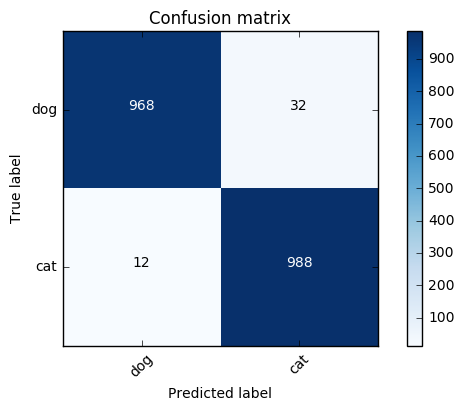

In [44]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## Retraining more layers

In [34]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

Since we haven't changed our architecture, there's no need to re-compile the model - instead, we just set the learning rate. Since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously.

In [35]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
23000/23000 [==============================] - 631s - loss: 0.4413 - acc: 0.9719 - val_loss: 0.3280 - val_acc: 0.9785
Epoch 2/3
23000/23000 [==============================] - 632s - loss: 0.4311 - acc: 0.9725 - val_loss: 0.3305 - val_acc: 0.9795
Epoch 3/3
23000/23000 [==============================] - 627s - loss: 0.4552 - acc: 0.9712 - val_loss: 0.3197 - val_acc: 0.9800


In [36]:
model.save_weights(model_path+'finetune2.h5')

## Prediction

Load model weights if needed:

In [24]:
model.load_weights(model_path+'finetune2.h5')

Load test data

In [37]:
gen = image.ImageDataGenerator()
test_batches = gen.flow_from_directory(path+'test', target_size, class_mode=None, shuffle=False, batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [38]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

## Submission

In [39]:
# Extract image ids from the file names
file_id = np.array([int(f[8:f.find('.')]) for f in test_batches.filenames])

# Index 1 is the probability that the image is a dog
is_dog = preds[:, 1]

# Tweak over confident result
# is_dog = is_dog.clip(min=0.05, max=0.95)
is_dog = is_dog.clip(min=0.015, max=0.985)

# Join two arrays
subm = np.stack([file_id, is_dog], axis=1)

In [41]:
results_path = path + 'results/'
if not os.path.exists(results_path): os.mkdir(results_path)

submission_file_name = results_path+'submission2.1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')